In [514]:
# importing all packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from sklearn.linear_model import LinearRegression, Lasso, LassoCV, ElasticNet, Ridge, RidgeCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures

plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [515]:
# reading the files into dataframes
df_train = pd.read_csv('./datasets/train.csv')
df_test = pd.read_csv('./datasets/test.csv')

In [516]:
# replacing indices in the training and testing dataframes with ID column
df_train.set_index('Id', inplace = True)
df_test.set_index('Id', inplace = True)

In [517]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2051 entries, 109 to 10
Data columns (total 80 columns):
PID                2051 non-null int64
MS SubClass        2051 non-null int64
MS Zoning          2051 non-null object
Lot Frontage       1721 non-null float64
Lot Area           2051 non-null int64
Street             2051 non-null object
Alley              140 non-null object
Lot Shape          2051 non-null object
Land Contour       2051 non-null object
Utilities          2051 non-null object
Lot Config         2051 non-null object
Land Slope         2051 non-null object
Neighborhood       2051 non-null object
Condition 1        2051 non-null object
Condition 2        2051 non-null object
Bldg Type          2051 non-null object
House Style        2051 non-null object
Overall Qual       2051 non-null int64
Overall Cond       2051 non-null int64
Year Built         2051 non-null int64
Year Remod/Add     2051 non-null int64
Roof Style         2051 non-null object
Roof Matl          2

In [518]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 878 entries, 2658 to 1939
Data columns (total 79 columns):
PID                878 non-null int64
MS SubClass        878 non-null int64
MS Zoning          878 non-null object
Lot Frontage       718 non-null float64
Lot Area           878 non-null int64
Street             878 non-null object
Alley              58 non-null object
Lot Shape          878 non-null object
Land Contour       878 non-null object
Utilities          878 non-null object
Lot Config         878 non-null object
Land Slope         878 non-null object
Neighborhood       878 non-null object
Condition 1        878 non-null object
Condition 2        878 non-null object
Bldg Type          878 non-null object
House Style        878 non-null object
Overall Qual       878 non-null int64
Overall Cond       878 non-null int64
Year Built         878 non-null int64
Year Remod/Add     878 non-null int64
Roof Style         878 non-null object
Roof Matl          878 non-null object
E

## Cleaning Data ##
### Dropping 2 largest outliers first ###

In [519]:
# While running all models, we have found 2 extraordinary outliers
df_train.drop([2181, 1499], inplace = True)

### Replacing Null Values ###

In [520]:
# We need to convert the Ordinal string data into numbers to feed into our linear regression model
# Data dictionary provided in this project reveals the ranking system in English. We have interpretted these to numbers. 
# need to provide a link for this in the README

rating_dict = {'Ex': 5,'Gd': 4,'TA': 3,'Fa': 2,'Po': 1, np.nan : 0, 'NA': 0}
bsmt_expo_dict = {'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1, np.nan: 0, 'NA': 0}
bsmt_fin_dict = {'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, np.nan: 0, 'NA': 0}
electrical_dict = {'SBrkr': 5, 'FuseA': 4, 'FuseF': 3, 'FuseP': 2, 'Mix': 1, np.nan: 0, 'NA': 0}
fence_dict = {'GdPrv': 4, 'MnPrv': 3, 'GdWo': 2, 'MnWw': 1, np.nan: 0, 'NA': 0}
functional_dict = {'Typ': 8, 'Min1': 7, 'Min2': 6, 'Mod': 5, 'Maj1': 4, 'Maj2': 3, 'Sev': 2, 'Sal':1, np.nan: 0, 'NA': 0}
garage_finish_dict = {'Fin': 3, 'RFn': 2, 'Unf': 1, np.nan: 0, 'NA': 0}
land_slope_dict = {'Gtl': 3, 'Mod': 2, 'Sev': 1, np.nan: 0, 'NA': 0}
lot_shape_dict = {'Reg': 4, 'IR1': 3, 'IR2': 2, 'IR3': 1, np.nan: 0, 'NA': 0}
paved_drive_dict = {'Y': 3, 'P': 2, 'N': 1, np.nan: 0, 'NA': 0}
pool_qc_dict = {'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1, np.nan: 0, 'NA': 0}
utilities_dict = {'AllPub': 4, 'NoSewr': 3, 'NoSeWa': 2, 'ELO': 1, np.nan: 0, 'NA': 0}

In [521]:
# Converting ordinal features from TRAINING data into numbers
df_train['Bsmt Cond'].replace(rating_dict, inplace = True)
df_train['Bsmt Qual'].replace(rating_dict, inplace = True)
df_train['Exter Cond'].replace(rating_dict, inplace = True)
df_train['Exter Qual'].replace(rating_dict, inplace = True)
df_train['Fireplace Qu'].replace(rating_dict, inplace = True)
df_train['Garage Cond'].replace(rating_dict, inplace = True) 
df_train['Garage Qual'].replace(rating_dict, inplace = True)
df_train['Heating QC'].replace(rating_dict, inplace = True)
df_train['Kitchen Qual'].replace(rating_dict, inplace = True)
df_train['BsmtFin Type 1'].replace(bsmt_fin_dict, inplace = True)
df_train['BsmtFin Type 2'].replace(bsmt_fin_dict, inplace = True)
df_train['Bsmt Exposure'].replace(bsmt_expo_dict, inplace = True)
df_train['Electrical'].replace(electrical_dict, inplace = True)
df_train['Fence'].replace(fence_dict, inplace = True)
df_train['Functional'].replace(functional_dict, inplace = True)
df_train['Garage Finish'].replace(garage_finish_dict, inplace = True)
df_train['Land Slope'].replace(land_slope_dict, inplace = True)
df_train['Lot Shape'].replace(lot_shape_dict, inplace = True)
df_train['Paved Drive'].replace(paved_drive_dict, inplace = True)
df_train['Pool QC'].replace(pool_qc_dict, inplace = True)
df_train['Utilities'].replace(utilities_dict, inplace = True)

In [522]:
# Converting ordinal features from TESTING data into numbers
df_test['Bsmt Cond'].replace(rating_dict, inplace = True)
df_test['Bsmt Qual'].replace(rating_dict, inplace = True)
df_test['Exter Cond'].replace(rating_dict, inplace = True)
df_test['Exter Qual'].replace(rating_dict, inplace = True)
df_test['Fireplace Qu'].replace(rating_dict, inplace = True)
df_test['Garage Cond'].replace(rating_dict, inplace = True) 
df_test['Garage Qual'].replace(rating_dict, inplace = True)
df_test['Heating QC'].replace(rating_dict, inplace = True)
df_test['Kitchen Qual'].replace(rating_dict, inplace = True)
df_test['BsmtFin Type 1'].replace(bsmt_fin_dict, inplace = True)
df_test['BsmtFin Type 2'].replace(bsmt_fin_dict, inplace = True)
df_test['Bsmt Exposure'].replace(bsmt_expo_dict, inplace = True)
df_test['Electrical'].replace(electrical_dict, inplace = True)
df_test['Fence'].replace(fence_dict, inplace = True)
df_test['Functional'].replace(functional_dict, inplace = True)
df_test['Garage Finish'].replace(garage_finish_dict, inplace = True)
df_test['Land Slope'].replace(land_slope_dict, inplace = True)
df_test['Lot Shape'].replace(lot_shape_dict, inplace = True)
df_test['Paved Drive'].replace(paved_drive_dict, inplace = True)
df_test['Pool QC'].replace(pool_qc_dict, inplace = True)
df_test['Utilities'].replace(utilities_dict, inplace = True)

In [523]:
# checking null values in TRAINING
df_train.isnull().sum().sort_values(ascending = False).head(16)

Misc Feature      1985
Alley             1909
Lot Frontage       330
Garage Yr Blt      114
Garage Type        113
Mas Vnr Type        22
Mas Vnr Area        22
Bsmt Full Bath       2
Bsmt Half Bath       2
Garage Area          1
BsmtFin SF 2         1
Bsmt Unf SF          1
Total Bsmt SF        1
Garage Cars          1
BsmtFin SF 1         1
SalePrice            0
dtype: int64

In [524]:
# checking null values of TESTING data.
df_test.isnull().sum().sort_values(ascending = False).head(8)

Misc Feature     837
Alley            820
Lot Frontage     160
Garage Yr Blt     45
Garage Type       44
Mas Vnr Type       1
Mas Vnr Area       1
Exter Qual         0
dtype: int64

In [525]:
# creating dictionary to replace ALL null values
# nominal features will be replaced with 'None'
nominal_dict = {np.nan:'None'}

# Continuous features will be replaced with the mean values of those features.
lot_frontage_dict = {np.nan: df_train['Lot Frontage'].mean()}
mas_vnr_area_dict = {np.nan: df_train['Mas Vnr Area'].mean()}
bsmtFin_SF_2_dict = {np.nan: df_train['BsmtFin SF 2'].mean()}
garage_area_dict = {np.nan: df_train['Garage Area'].mean()}
bmst_unf_sf_dict = {np.nan: df_train['Bsmt Unf SF'].mean()}
total_bsmt_sf_dict = {np.nan: df_train['Total Bsmt SF'].mean()}
bmst_fin_sf_1_dict = {np.nan: df_train['BsmtFin SF 1'].mean()}

# Discrete features will be replaced with the median values
garage_yr_blt_dict = {np.nan: df_train['Garage Yr Blt'].median()}
bsmt_full_bath_dict = {np.nan: df_train['Bsmt Full Bath'].median()}
bsmt_half_bath_dict = {np.nan: df_train['Bsmt Half Bath'].median()}
garage_cars_dict = {np.nan: df_train['Garage Cars'].median()}

In [526]:
# Replacing nulls in TRAINING data
# Nominal features
df_train['Garage Type'].replace(nominal_dict, inplace = True)
df_train['Mas Vnr Type'].replace(nominal_dict, inplace = True)
df_train['Misc Feature'].replace(nominal_dict, inplace = True)
df_train['Alley'].replace(nominal_dict, inplace = True)

# remaining features
df_train['Lot Frontage'].replace(lot_frontage_dict, inplace = True)
df_train['Mas Vnr Area'].replace(mas_vnr_area_dict, inplace = True)
df_train['Garage Yr Blt'].replace(garage_yr_blt_dict, inplace = True)
df_train['Bsmt Full Bath'].replace(bsmt_full_bath_dict, inplace = True)
df_train['Bsmt Half Bath'].replace(bsmt_half_bath_dict, inplace = True)
df_train['BsmtFin SF 2'].replace(bsmtFin_SF_2_dict, inplace = True)
df_train['Garage Cars'].replace(garage_cars_dict, inplace = True)
df_train['Garage Area'].replace(garage_area_dict, inplace = True)
df_train['Bsmt Unf SF'].replace(bmst_unf_sf_dict, inplace = True)
df_train['Total Bsmt SF'].replace(total_bsmt_sf_dict, inplace = True)
df_train['BsmtFin SF 1'].replace(bmst_fin_sf_1_dict, inplace = True)

In [527]:
# Replacing nulls in TESTING data
# nominal features
df_test['Garage Type'].replace(nominal_dict, inplace = True)
df_test['Mas Vnr Type'].replace(nominal_dict, inplace = True)
df_test['Misc Feature'].replace(nominal_dict, inplace = True)
df_test['Alley'].replace(nominal_dict, inplace = True)

# remaining features
df_test['Lot Frontage'].replace(lot_frontage_dict, inplace = True)
df_test['Mas Vnr Area'].replace(mas_vnr_area_dict, inplace = True)
df_test['Garage Yr Blt'].replace(garage_yr_blt_dict, inplace = True)
df_test['Bsmt Full Bath'].replace(bsmt_full_bath_dict, inplace = True)
df_test['Bsmt Half Bath'].replace(bsmt_half_bath_dict, inplace = True)
df_test['BsmtFin SF 2'].replace(bsmtFin_SF_2_dict, inplace = True)
df_test['Garage Cars'].replace(garage_cars_dict, inplace = True)
df_test['Garage Area'].replace(garage_area_dict, inplace = True)
df_test['Bsmt Unf SF'].replace(bmst_unf_sf_dict, inplace = True)
df_test['Total Bsmt SF'].replace(total_bsmt_sf_dict, inplace = True)
df_test['BsmtFin SF 1'].replace(bmst_fin_sf_1_dict, inplace = True)

In [528]:
# checking remaining null values in the TRAINING data
df_train.isnull().sum().sort_values(ascending = False).head(2)

SalePrice    0
Sale Type    0
dtype: int64

In [529]:
# checking remaining null values in the TESTING data
df_test.isnull().sum().sort_values(ascending = False).head(2)

Sale Type     0
Exter Cond    0
dtype: int64

### Interaction ###
#### original test


In [530]:
# interactions on Training data
# df_train['Half * Full Bath'] = df_train['Full Bath'] * df_train['Half Bath']
# df_train['1st * 2nd Flr SF'] = df_train['1st Flr SF'] * df_train['2nd Flr SF'] 
# first floor is more correlated than the combination of the two
# df_train['Fireplaces * Qu'] = df_train['Fireplaces'] * df_train['Fireplace Qu']

# Interactions Testing
# df_test['Half * Full Bath'] = df_test['Full Bath'] * df_test['Half Bath']
# df_test['1st * 2nd Flr SF'] = df_test['1st Flr SF'] * df_test['2nd Flr SF']
# df_test['Fireplaces * Qu'] = df_test['Fireplaces'] * df_test['Fireplace Qu']      

In [531]:
df_train.shape

(2049, 80)

In [532]:
df_test.shape

(878, 79)

### Get Dummies

In [533]:
# Getting dummies for all Nominal Features
nominal_features = ['Mas Vnr Type', 'MS SubClass', 'MS Zoning', 'Street', 'Misc Feature', 'Land Contour', 
                     'Lot Config', 'Neighborhood', 'Condition 1', 'Condition 2', 'Bldg Type', 'House Style',
                     'Roof Style', 'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Alley', 'Foundation',
                     'Garage Type', 'Heating', 'Central Air', 'Sale Type']

In [534]:
# getting Dummies for categorizations - Nominal features
df_train = pd.get_dummies(data = df_train, columns = nominal_features)
df_test = pd.get_dummies(data = df_test, columns = nominal_features)

In [535]:
df_test.shape

(878, 222)

In [536]:
df_train.shape

(2049, 232)

In [537]:
set(df_test.columns) - set(df_train.columns)

{'Exterior 1st_PreCast',
 'Exterior 2nd_Other',
 'Exterior 2nd_PreCast',
 'Heating_Floor',
 'Mas Vnr Type_CBlock',
 'Roof Matl_Metal',
 'Roof Matl_Roll',
 'Sale Type_VWD'}

In [538]:
set(df_train.columns) - set(df_test.columns)

{'Condition 2_Artery',
 'Condition 2_PosN',
 'Condition 2_RRAe',
 'Condition 2_RRAn',
 'Condition 2_RRNn',
 'Exterior 1st_CBlock',
 'Exterior 1st_ImStucc',
 'Exterior 1st_Stone',
 'Exterior 2nd_Stone',
 'Heating_OthW',
 'Heating_Wall',
 'MS SubClass_150',
 'MS Zoning_A (agr)',
 'Misc Feature_TenC',
 'Neighborhood_GrnHill',
 'Neighborhood_Landmrk',
 'Roof Matl_Membran',
 'SalePrice'}

### Same columns on both dataframes ###

In [539]:
# provides the columns that exist in Train that do NOT exist in Test (and vice versa0)
add_columns_to_train = set(df_test.columns) - set(df_train.columns)
add_columns_to_test = set(df_train.columns) - set(df_test.columns)

# Add columns that were exclusive to test.csv to df_train (and vice versa)
for col in add_columns_to_train:
    df_train[col] = 0
for col in add_columns_to_test:
    df_test[col] = 0

# Reorder df_train to match df_test columns
df_train = df_train[df_test.columns]

# Removing SalePrice from Test
df_test = df_test.drop('SalePrice', axis = 1)

In [540]:
df_train.shape

(2049, 240)

In [541]:
df_test.shape

(878, 239)

In [542]:
# drops first column of the group of dummy columns 
for nom in nominal_features:
    dummy_list = [col for col in df_train.columns if nom in col]
    df_train.drop(columns = dummy_list[0], inplace = True)
    df_test.drop(columns = dummy_list[0], inplace = True)

In [543]:
set(df_train.columns) - set(df_test.columns)

{'SalePrice'}

In [544]:
# converting the object data types into float64 for both test and training data so we can run a regression
df_train = df_train.astype('float64')
df_test = df_test.astype('float64')

In [545]:
df_train.shape

(2049, 218)

In [546]:
df_test.shape

(878, 217)

### Reviewing Correlations

In [547]:
# finding correlation values
pd.set_option('display.max_rows', 259)
df_train.corr()[['SalePrice']].sort_values('SalePrice')

,SalePrice
Mas Vnr Type_None,-0.411630
Garage Type_Detchd,-0.370485
Foundation_CBlock,-0.355768
Lot Shape,-0.296743
MS Zoning_RM,-0.282032
PID,-0.255068
Roof Style_Gable,-0.250019
MS SubClass_30,-0.248572
Garage Type_None,-0.231030
Sale Type_WD,-0.213536


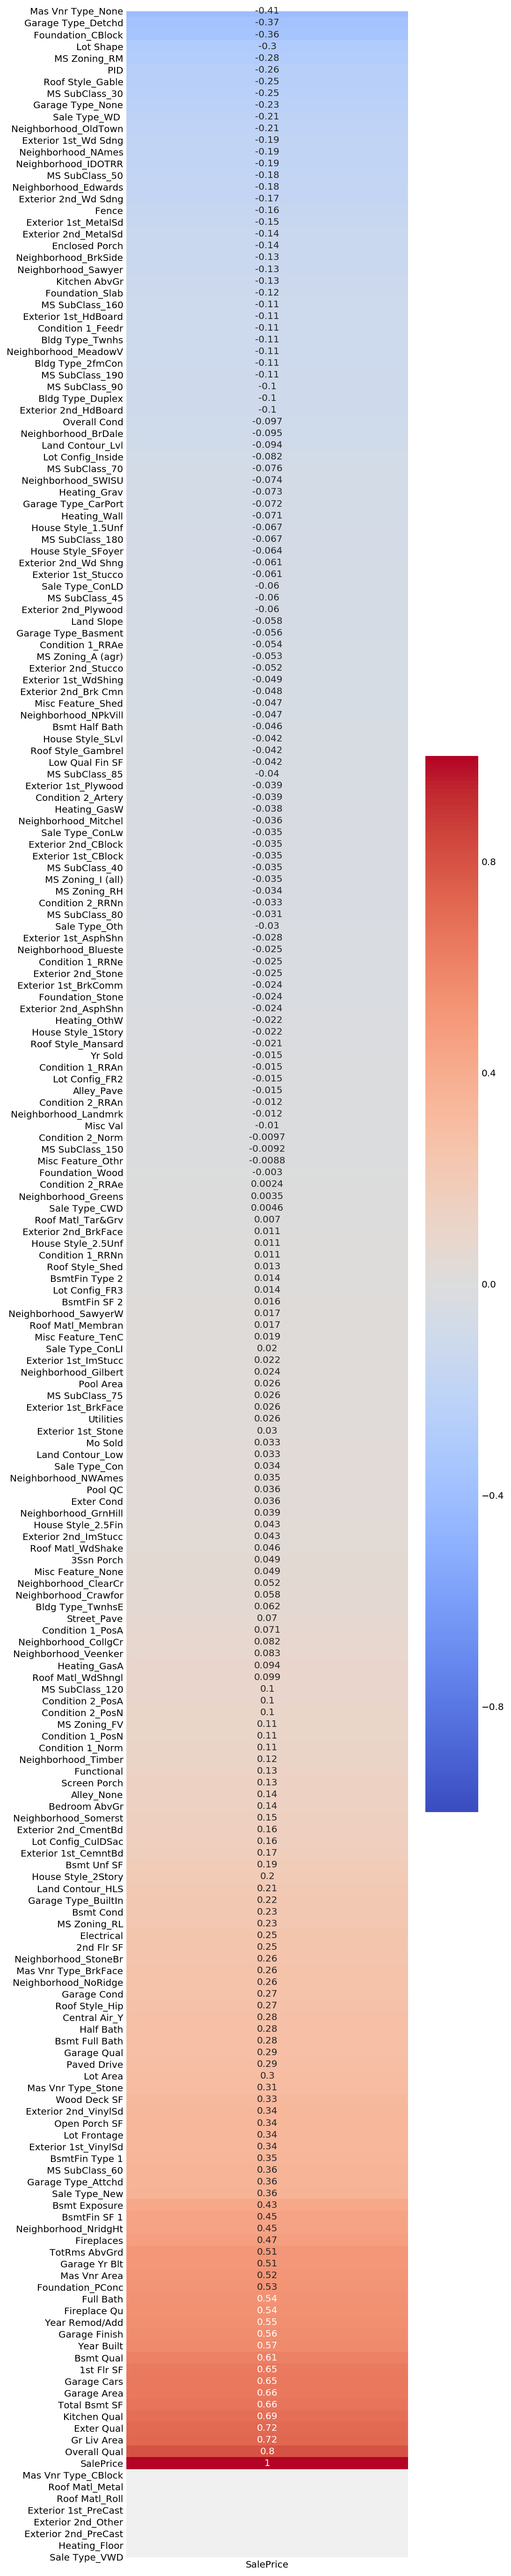

In [548]:
plt.figure(figsize = (6, 50)) # this figsizes are in inches wide and tall
# need to specify which column you want to sort by, even though there is only 1 column
sns.heatmap(df_train.corr()[['SalePrice']].sort_values('SalePrice'),
            cmap = 'coolwarm',
            vmin = -1,
            vmax = 1,
            annot=True);

### Feature Selection

In [549]:
# We will keep all features above 0.5 correlation, exclude the features below 0.5 correlation.
# Dropping each dummied nominal feature column

for col in df_train.columns:
    for nom in nominal_features:
        if nom in col:
            df_train.drop(columns = col, inplace = True)
    
for col in df_test.columns:
    for nom in nominal_features:
        if nom in col:
            df_test.drop(columns = col, inplace = True)

In [550]:
# Listing the remaining features to drop

excluded_features = ['PID',
                     
#continuous features
                     '2nd Flr SF', '3Ssn Porch', 'Bsmt Unf SF', 'BsmtFin SF 1', 'BsmtFin SF 2', 'Enclosed Porch',
                     'Lot Area', 'Lot Frontage', 'Low Qual Fin SF', 'Misc Val', 'Open Porch SF', 'Pool Area', 
                     'Screen Porch', 'Wood Deck SF',                    
# ordinal features
                     'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin Type 2', 'Electrical', 'Exter Cond', 
                     'Fence', 'Functional', 'Garage Cond', 'Garage Qual', 'Land Slope', 'Lot Shape', 'Overall Cond', 
                     'Paved Drive', 'Pool QC', 'Utilities',

# discrete features
                     'Bedroom AbvGr', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Fireplaces', 'Half Bath', 'Kitchen AbvGr',
                     'Mo Sold', 'Yr Sold']

In [551]:
# dropping remaining features for both dataframes
df_train.drop(columns = excluded_features, inplace = True)
df_test.drop(columns = excluded_features, inplace = True)

In [552]:
# finding correlation values
df_train.corr()[['SalePrice']].sort_values('SalePrice')

,SalePrice
TotRms AbvGrd,0.509775
Garage Yr Blt,0.514436
Mas Vnr Area,0.516341
Full Bath,0.538225
Fireplace Qu,0.539484
Year Remod/Add,0.550872
Garage Finish,0.558566
Year Built,0.572405
Bsmt Qual,0.613236
1st Flr SF,0.648252


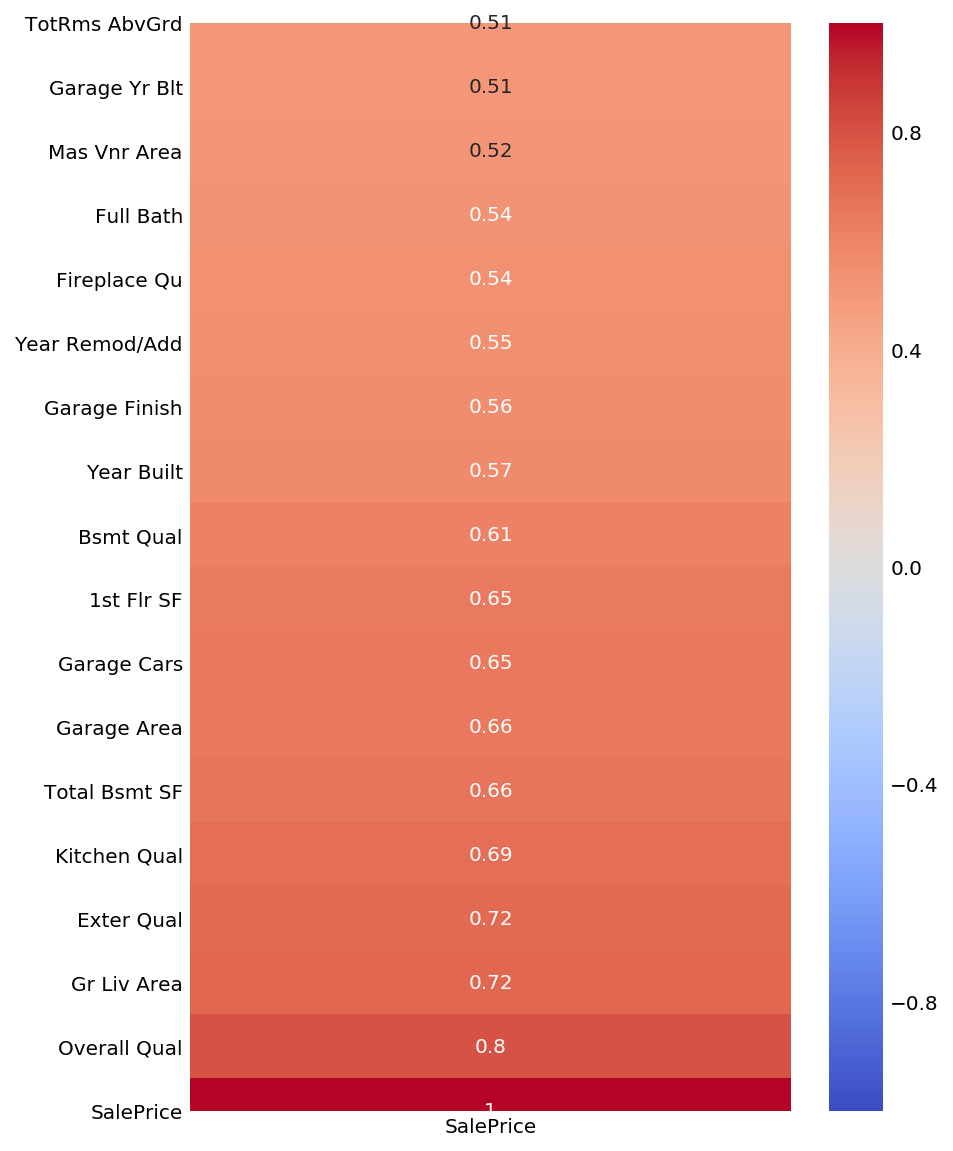

In [553]:
plt.figure(figsize = (6, 10)) # this figsizes are in inches wide and tall
# need to specify which column you want to sort by, even though there is only 1 column
sns.heatmap(df_train.corr()[['SalePrice']].sort_values('SalePrice'),
            cmap = 'coolwarm',
            vmin = -1,
            vmax = 1,
            annot=True);

In [554]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2049 entries, 109 to 10
Data columns (total 18 columns):
Overall Qual      2049 non-null float64
Year Built        2049 non-null float64
Year Remod/Add    2049 non-null float64
Mas Vnr Area      2049 non-null float64
Exter Qual        2049 non-null float64
Bsmt Qual         2049 non-null float64
Total Bsmt SF     2049 non-null float64
1st Flr SF        2049 non-null float64
Gr Liv Area       2049 non-null float64
Full Bath         2049 non-null float64
Kitchen Qual      2049 non-null float64
TotRms AbvGrd     2049 non-null float64
Fireplace Qu      2049 non-null float64
Garage Yr Blt     2049 non-null float64
Garage Finish     2049 non-null float64
Garage Cars       2049 non-null float64
Garage Area       2049 non-null float64
SalePrice         2049 non-null float64
dtypes: float64(18)
memory usage: 304.1 KB


In [555]:
#OLS on a test
X_ols = sm.add_constant(X)
est = sm.OLS(y, X.astype(float)).fit()
est.summary()

C:\Users\16463\AppData\Local\Continuum\anaconda3\envs\dsi\lib\site-packages\numpy\core\fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              SalePrice   R-squared (uncentered):                   0.971
Model:                            OLS   Adj. R-squared (uncentered):              0.971
Method:                 Least Squares   F-statistic:                              4011.
Date:                Wed, 15 Jan 2020   Prob (F-statistic):                        0.00
Time:                        22:16:34   Log-Likelihood:                         -24292.
No. Observations:                2051   AIC:                                  4.862e+04
Df Residuals:                    2034   BIC:                                  4.871e+04
Df Model:                          17                                                  
Covariance Type:            nonrobust                                                  
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Overall Qual    1.147e+04   1000.176     11.473      0.000    9513.349    1.34e+04
Year Built        41.5726     46.430      0.895      0.371     -49.484     132.629
Year Remod/Add   -29.5877     42.454     -0.697      0.486    -112.846      53.671
Mas Vnr Area      37.2339      5.067      7.349      0.000      27.298      47.170
Exter Qual      1.645e+04   2194.872      7.496      0.000    1.21e+04    2.08e+04
Bsmt Qual       9309.9717   1354.983      6.871      0.000    6652.672     1.2e+04
Total Bsmt SF      5.0865      3.566      1.426      0.154      -1.907      12.080
1st Flr SF        21.4912      3.907      5.501      0.000      13.830      29.153
Gr Liv Area       33.2570      3.361      9.895      0.000      26.666      39.848
Full Bath       -335.2352   1893.876     -0.177      0.860   -4049.375    3378.905
Kitchen Qual    1.544e+04   1784.339      8.654      0.000    1.19e+04    1.89e+04
TotRms AbvGrd    891.7125    853.500      1.045      0.296    -782.112    2565.538
Fireplace Qu    3604.2507    509.176      7.079      0.000    2605.690    4602.811
Garage Yr Blt    -89.2323     50.637     -1.762      0.078    -188.538      10.074
Garage Finish   2558.1285   1151.253      2.222      0.026     300.370    4815.887
Garage Cars     2866.9881   2411.098      1.189      0.235   -1861.492    7595.468
Garage Area       35.4118      8.343      4.245      0.000      19.050      51.773
==============================================================================
Omnibus:                      885.435   Durbin-Watson:                   2.031
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            78622.646
Skew:                          -1.102   Prob(JB):                         0.00
Kurtosis:                      33.251   Cond. No.                     1.37e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.37e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Testing the model

In [556]:
# Dropping remaining outliers FOR TESTING.
# df_train.drop([434, 1183, 1783, 2333], inplace = True)

# Ridge
# df_train.drop([1183, 1783, 1641, 45], inplace = True)

# other ones [1560, 1697, 1700, 45, 2257]

#2333, 1641, 2116 keep these, or we'll worsen the score

In [557]:
# setting X and y variables
X = df_train.drop(columns = 'SalePrice')
y = df_train['SalePrice']

### Train Test Split

In [558]:
# running Train Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [559]:
# Instantiate Standard Scaler.
sc = StandardScaler()

# Fit AND transform Standard Scaler to data in one step.
Z_train = sc.fit_transform(X_train)
Z_test = sc.transform(X_test)

In [560]:
y_train_log = np.log(y_train)
y_test_log = np.log(y_test)

In [561]:
# plot predictions function
def plot_predictions(predictions):

    # plotting training data for Y hat vs actual Y to find outliers
    plt.figure(figsize=(10,5))

    # Generate a scatterplot of carat versus price.
    plt.scatter(predictions,
                y_train,
                alpha = 0.5)

    plt.xlabel('Predictions', fontsize = 15)
    plt.ylabel('Actual Sale Price', fontsize = 15)
    plt.title("Predicting Housing Prices", fontsize = 24)

    # attempting to annot each value
    training = 0
    for i, txt in y_train.iteritems():
        plt.annotate(i, (predictions[training], y_train[i]))
        training += 1

    # plot the regression line
    plt.plot(predictions,
             predictions,
             color = 'red');
    return

### Linear Regression

In [562]:
# Linear Regression
lr = LinearRegression()
lr.fit(Z_train, y_train_log) # or y_train_log

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [563]:
# predicting values for linear regression
y_hat_lr_train = lr.predict(Z_train) # or y_hat_lr_train_log
y_hat_lr_test = lr.predict(Z_test) # or y_hat_lr_test_log

In [564]:
# need to test
preds_lr_train = np.exp(y_hat_lr_train)
preds_lr_test = np.exp(y_hat_lr_test)

In [565]:
# # this is the 5 fold cross val score
# cross_val_score(lr, X_train, y_train, cv=5).mean()

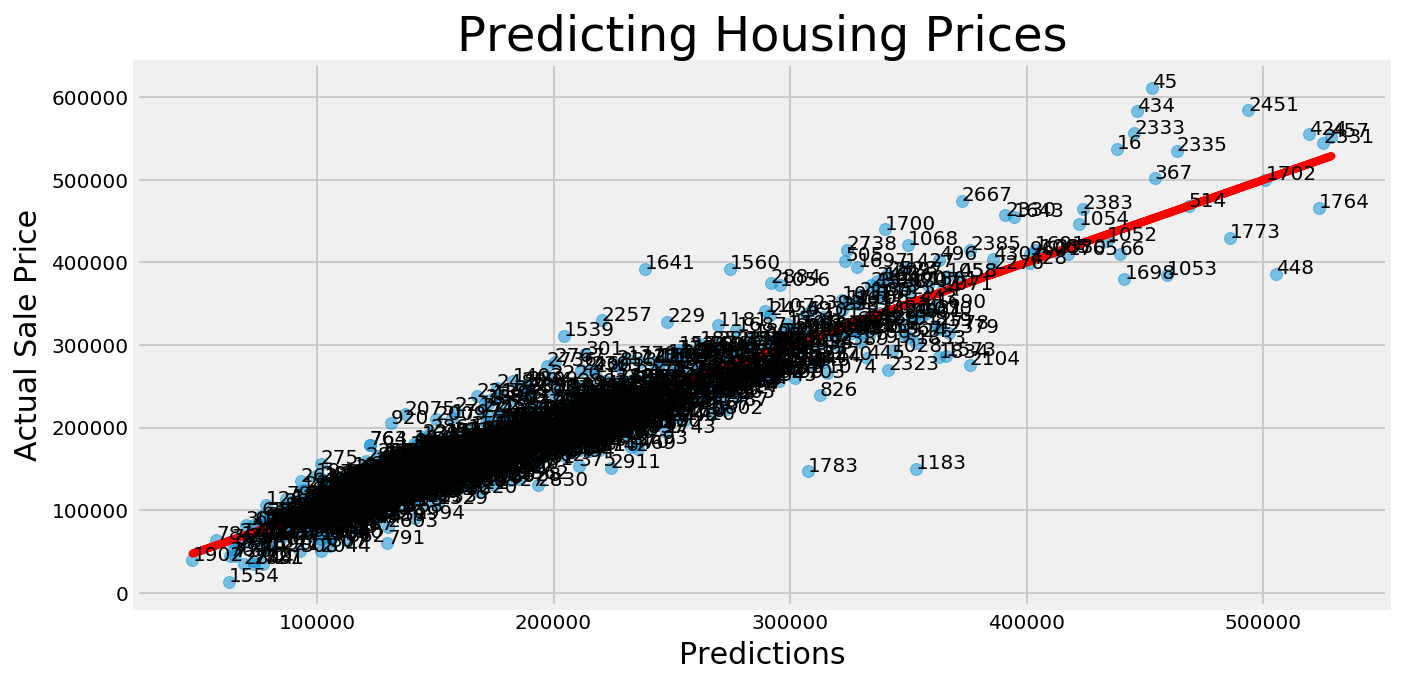

In [566]:
plot_predictions(preds_lr_train)

### Ridge Regression ###

In [567]:
# Set up a list of ridge alphas to check.
# Generates 100 values equally between 0 and 5,
# then converts them to alphas between 10^0 and 10^5.
ridge_alphas = np.linspace(10, 15, 100)

# Cross-validate over our list of ridge alphas.
ridge_cv = RidgeCV(
    alphas = ridge_alphas,
    scoring = "r2",
    cv = 5) #How many folds

# Fit model using best ridge alpha!
ridge_cv.fit(Z_train, y_train_log) # or y_train log 

RidgeCV(alphas=array([10.        , 10.05050505, 10.1010101 , 10.15151515, 10.2020202 ,
       10.25252525, 10.3030303 , 10.35353535, 10.4040404 , 10.45454545,
       10.50505051, 10.55555556, 10.60606061, 10.65656566, 10.70707071,
       10.75757576, 10.80808081, 10.85858586, 10.90909091, 10.95959596,
       11.01010101, 11.06060606, 11.11111111, 11.16161616, 11.21212121,
       11.26262626, 11.31313131, 11.36363636, 11.4...
       13.78787879, 13.83838384, 13.88888889, 13.93939394, 13.98989899,
       14.04040404, 14.09090909, 14.14141414, 14.19191919, 14.24242424,
       14.29292929, 14.34343434, 14.39393939, 14.44444444, 14.49494949,
       14.54545455, 14.5959596 , 14.64646465, 14.6969697 , 14.74747475,
       14.7979798 , 14.84848485, 14.8989899 , 14.94949495, 15.        ]),
        cv=5, fit_intercept=True, gcv_mode=None, normalize=False, scoring='r2',
        store_cv_values=False)

In [568]:
# Optimal Alpha
ridge_cv.alpha_

12.525252525252526

In [569]:
print(ridge_cv.score(Z_train, y_train))
print(ridge_cv.score(Z_test, y_test))

-5.250516387448491
-5.20749933153653


In [570]:
# fitting
ridge = Ridge(alpha = ridge_cv.alpha_)
ridge.fit(Z_train, y_train_log) # or y_train_log

Ridge(alpha=12.525252525252526, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [571]:
# predicting values with Ridge
y_hat_ridge_train = ridge.predict(Z_train) # these are log versions
y_hat_ridge_test = ridge.predict(Z_test)

In [572]:
# Final Ridge predictions
preds_ridge_train = np.exp(y_hat_ridge_train)
preds_ridge_test = np.exp(y_hat_ridge_test)

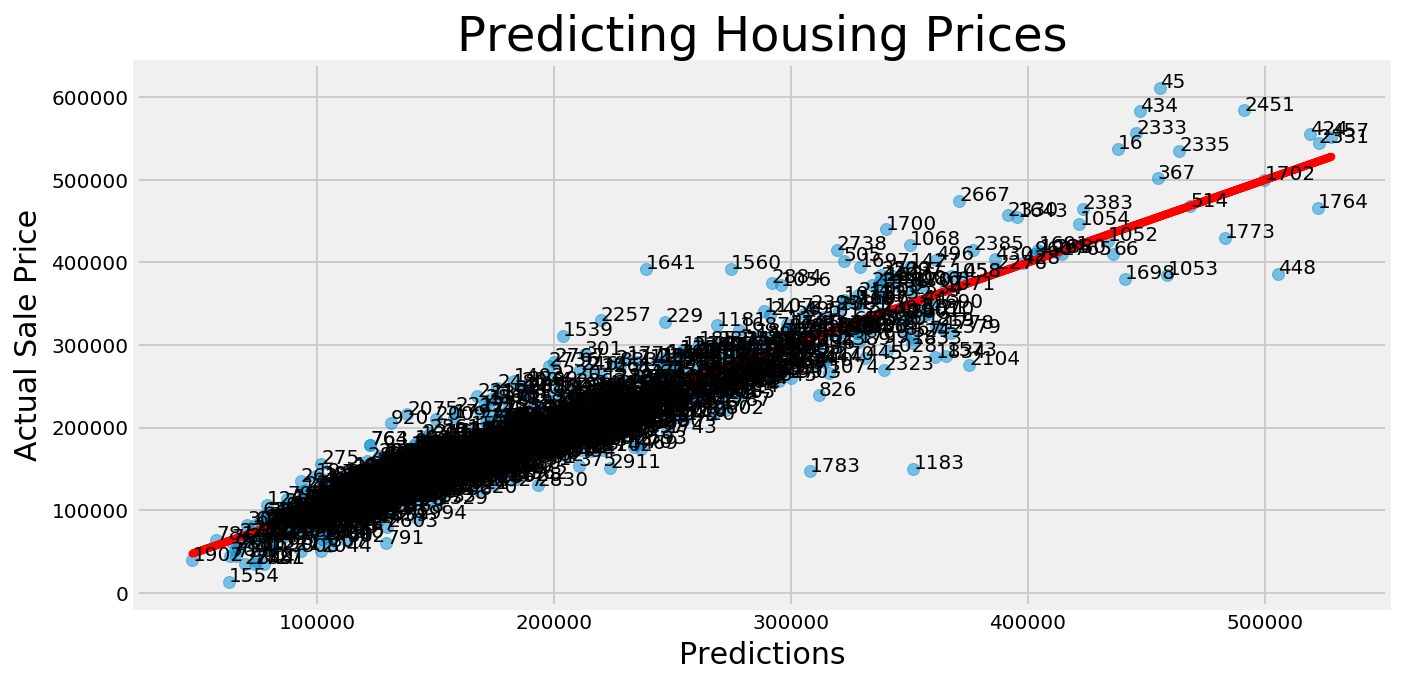

In [573]:
plot_predictions(preds_ridge_train)

### LASSO

In [894]:
# # Set up a list of Lasso alphas to check.
# lasso_alphas = np.logspace(-3, 0, 100)

# # Cross-validate over our list of Lasso alphas.
# lasso = LassoCV(
#     alphas = lasso_alphas,
#     cv = 5,
#     max_iter = 5000)

# # Fit model using best ridge alpha!
# lasso.fit(Z_train, y_train)

In [895]:
# lasso.alpha_

In [896]:
# print(lasso.score(Z_train, y_train))
# print(lasso.score(Z_test, y_test))

In [897]:
# cross_val_score(lr, X, y, cv = 5).mean()

In [903]:
# Mean Squared Errors for Y Training
np.sqrt(mean_squared_error(y_train, preds_ridge_train)) # keep updating y_test values here for the models

16516.150052421766

In [909]:
# test data linear regression RMSE
np.sqrt(mean_squared_error(y_test, preds_ridge_test)) # keep updating y_test values here for the models

21028.145983614635

### Kaggle

In [906]:
X_kaggle = df_test

In [907]:
X_kaggle_sc = sc.transform(X_kaggle)

In [1944]:
# # Linear Regression
# preds_kaggle_log = lr.predict(X_kaggle_sc)
# X_kaggle['SalePrice'] = np.exp(preds_kaggle_log)

In [ ]:
# Ridge Regression
preds_kaggle_log = ridge.predict(X_kaggle_sc)
X_kaggle['SalePrice'] = np.exp(preds_kaggle_log)

In [ ]:
# LASSO Regression
preds_kaggle_log = lr.predict(X_kaggle_sc)
X_kaggle['SalePrice'] = np.exp(preds_kaggle_log)

In [1945]:
X_kaggle.head()

,Lot Frontage,Lot Area,Lot Shape,Overall Qual,Year Built,Year Remod/Add,Mas Vnr Area,Exter Qual,Bsmt Qual,Bsmt Exposure,...,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Half * Full Bath,1st * 2nd Flr SF,Fireplaces * Qu,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
2658,69.0000,9142.0,4.0,6.0,1910.0,1950.0,0.0,3.0,2.0,1.0,...,440.0,1.0,1.0,3.0,0.0,60.0,0.0,926160.0,0.0,128570.797700
2718,69.0552,9662.0,3.0,5.0,1977.0,1977.0,0.0,3.0,4.0,1.0,...,580.0,3.0,3.0,3.0,170.0,0.0,0.0,0.0,0.0,171993.671151
2414,58.0000,17104.0,3.0,7.0,2006.0,2006.0,0.0,4.0,4.0,3.0,...,426.0,3.0,3.0,3.0,100.0,24.0,2.0,552448.0,4.0,215131.201779
1989,60.0000,8520.0,4.0,5.0,1923.0,2006.0,0.0,4.0,3.0,1.0,...,480.0,2.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,103186.439751
625,69.0552,9500.0,3.0,6.0,1963.0,1963.0,247.0,3.0,4.0,1.0,...,514.0,3.0,3.0,3.0,0.0,76.0,1.0,0.0,8.0,171031.970959


In [1946]:
output = X_kaggle[['SalePrice']]

In [1947]:
output

,SalePrice
Id,
2658,128570.797700
2718,171993.671151
2414,215131.201779
1989,103186.439751
625,171031.970959
...,...
1662,182329.826469
1234,216997.493554
1373,130128.098317


In [1948]:
# this is how we submit to kaggle
output.to_csv('./datasets/LowCorrelations_3InteractionsAdded_6OutliersRemoved_.csv')